In this notebook we are going to compute different connectivity measures and aggregate them into a dataframe. 

Broad picture: re-referenced iEEG data goes in, connectivity (usually within specific frequency bands) between electrodes comes out. Either one measure per trial (computed across timepoints), or one measure per timepoint (computed across trials)

To read more about implementation details for the different connectivity metrics here, read: https://mne.tools/mne-connectivity/stable/index.html

To read more about connectivity measures in iEEG data overall, read: 

Solomon, E.A. (2023). How Can I Analyze Connectivity in iEEG Data?. In: Axmacher, N. (eds) Intracranial EEG. Studies in Neuroscience, Psychology and Behavioral Economics. Springer, Cham. https://doi.org/10.1007/978-3-031-20910-9_32

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import os 
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')  # INSERT PATH TO LFPAnalysis package

In [4]:
from LFPAnalysis import oscillation_utils

ModuleNotFoundError: No module named 'LFPAnalysis'

## Example: computing coherence

In [ ]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

evs = {'gamble_start':[-1.0, 0], 
       'feedback_start': [0, 1.5]}

analysis_evs = ['feedback_start']

for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')

In [ ]:
metric = 'coh'
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))

freq_dict = {'theta':[2, 8], 
            'alpha':[8, 13],
            'beta': [13, 30], 
            'hfa': [70, 200]}

band0 = 'theta'
# don't really need this second term unless looking cross-frequency, but it's hard-coded in  
band1 = band1

buf_ms = 1000
n_surr = 500

savepath = '' # INSERT PATH TO SAVE DATA
if not os.path.exists(savepath):
    os.makedirs(savepath)

In [ ]:
# Example here: All-to-amygdala coherence 

pairs = (['AMY', 'HPC'], ['AMY', 'OFC'], ['AMY', 'dmPFC'], ['AMY', 'ACC'])

for pair in pairs:
    source_region = pair[0]
    target_region = pair[1]
    
    # initialize the storage list 
    conn_group_data = []

    # iterate through subjects
    for subj_id in subj_ids:
        for event in analysis_evs:
            loadpath = ''  # INSERT PATH TO LOAD RE-REFERENCED DATA
            epochs_reref = mne.read_epochs(f'{loadpath}/{event}-epo.fif', preload=True) # INSERT PATH TO LOAD RE-REFERENCED DATA

            # Get electrode df 
            elec_df = pd.read_csv('') # INSERT PATH TO LOAD ELECTRODE DATA

            # construct the seed-to-target mapping based on your rois - matters most for directional measures
            # I restrict this to intra-hemispheric connectivity by default - you can relax this assumption if need be
            seed_target_df = oscillation_utils.make_seed_target_df(elec_df, epochs_reref, source_region, target_region)

            # for cond in conditions: 
            for hemi in ['l', 'r']:
                # first determine if intra-hemispheric connectivity is even possible; if not, move on. 
                if hemi not in seed_target_df.index.tolist():
                    continue
                else:
                    seed_to_target = seed_target_indices(
                        seed_target_df['seed'][hemi],
                        seed_target_df['target'][hemi])
                
                if metric == 'amp':
                    pwise = oscillation_utils.compute_connectivity(epochs_reref.copy(), 
                                               band = freq_dict[band0], 
                                               metric = metric, 
                                               indices = seed_to_target, 
                                               freqs = None, 
                                               n_cycles = None,
                                               buf_ms = buf_ms, 
                                               n_surr=n_surr,
                                               avg_over_dim='time',
                                               band1 = freq_dict[band1])
                    
                elif metric == 'granger': 
                    pwise = oscillation_utils.compute_gc_tr(mne_data=epochs_reref.copy(), 
                            band=freq_dict[band0],
                            indices=seed_to_target, 
                            freqs=freqs, 
                            n_cycles=n_cycles,
                            rank=None, 
                            gc_n_lags=15, 
                            buf_ms=buf_ms, 
                            avg_over_dim='time')
                    
                else:
                    pwise = oscillation_utils.compute_connectivity(epochs_reref.copy(), 
                                               band = freq_dict[band0], 
                                               metric = metric, 
                                               indices = seed_to_target, 
                                               freqs = freqs, 
                                               n_cycles = n_cycles,
                                               buf_ms = buf_ms, 
                                               n_surr=n_surr,
                                               avg_over_dim='time',
                                               band1 = freq_dict[band1],
                                               parallelize=True)

                # Collect the data
                pwise_dfs = []

                if metric in ['gc', 'granger', 'cacoh']:
                    # no pairs here: computed over whole multivariate state space 
                    npairs=1
                else:
                    npairs = len(seed_to_target[0])
                    
                for pair in range(npairs): 
                    pwise_df = pd.DataFrame(columns=['participant', 'roi1', 'roi2', 'hemi', 'pair_label', 'metric', 'event', 'conn'])
                    pwise_df['conn'] = pwise[:, pair] 
                    pwise_df['participant'] = subj_id
                    pwise_df['age'] = subj_df[subj_df.MSSMCode==subj_id].Age.values[0]
                    pwise_df['sex'] = subj_df[subj_df.MSSMCode==subj_id].Sex.str.strip().values[0]
                    pwise_df['roi1'] = source_region
                    pwise_df['roi2'] = target_region
                    pwise_df['hemi'] = hemi 
                    pwise_df['metric'] = metric
                    pwise_df['event'] = event
                    pwise_df['band0'] = band0
                    pwise_df['band1'] =  band1
                    
                    # aggregate
                    pwise_dfs.append(pwise_df)
                pwise_dfs = pd.concat(pwise_dfs)
                conn_group_data.append(pwise_dfs)

    all_pairs_df = pd.concat(conn_group_data)
    all_pairs_df.to_csv(f'{savepath}/{source_region}_{target_region}_{metric}_{band0}_{band1}_{event}_df', index=False)



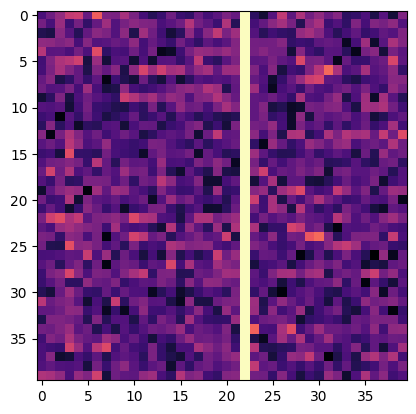

In [154]:
plt.imshow(pwise, cmap='magma')
